<a href="https://colab.research.google.com/github/aniray2908/silent-attrition-detector/blob/main/notebooks/hr_attrition_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Silent Attrition Risk Detection System

This notebook builds a production-style HR attrition risk engine using:

- CatBoost (gradient boosting)
- Class imbalance handling
- Threshold optimization
- SHAP interpretability
- Fairness auditing
- Deep learning comparison
- Ensemble modeling

The goal is to move beyond simple classification and build a calibrated, explainable risk scoring system.


## 1. Data Acquisition and Exploration

We begin by loading the IBM HR Analytics dataset and performing
basic exploratory data analysis to understand structure, class distribution,
and potential data quality issues.


In [1]:
import kagglehub
path = kagglehub.dataset_download("pavansubhasht/ibm-hr-analytics-attrition-dataset")

Using Colab cache for faster access to the 'ibm-hr-analytics-attrition-dataset' dataset.


In [2]:
import os

print(path)
print(os.listdir(path))

/kaggle/input/ibm-hr-analytics-attrition-dataset
['WA_Fn-UseC_-HR-Employee-Attrition.csv']


In [3]:
import pandas as pd

file_path = os.path.join(path, "WA_Fn-UseC_-HR-Employee-Attrition.csv")

df = pd.read_csv(file_path)

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [5]:
df["Attrition"].value_counts()
df["Attrition"].value_counts(normalize=True)

,proportion
Attrition,
No,0.838776
Yes,0.161224


In [6]:
df.nunique().sort_values()

,0
EmployeeCount,1
Over18,1
StandardHours,1
Attrition,2
OverTime,2
PerformanceRating,2
Gender,2
BusinessTravel,3
Department,3
MaritalStatus,3


## 2. Data Cleaning and Feature Preparation

We remove constant or identifier columns that do not contribute to prediction.
The target variable is converted into binary form.


In [7]:
columns_to_drop = [
    "EmployeeNumber",
    "Over18",
    "StandardHours",
    "EmployeeCount"
]

df = df.drop(columns=columns_to_drop)

In [8]:
df["Attrition"] = df["Attrition"].map({"Yes": 1, "No": 0})

In [9]:
df["Attrition"].value_counts()

,count
Attrition,
0,1233
1,237


In [10]:
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

In [11]:
categorical_cols = X.select_dtypes(include=["object"]).columns
numerical_cols = X.select_dtypes(exclude=["object"]).columns

print("Categorical:", len(categorical_cols))
print("Numerical:", len(numerical_cols))

Categorical: 7
Numerical: 23


In [12]:
df.isnull().sum().sum()

np.int64(0)

## 3. Baseline Model – CatBoost

CatBoost is a gradient boosting algorithm designed for tabular data.
It handles categorical features natively and typically performs strongly
on structured datasets.

We first train a baseline model without handling class imbalance.


In [13]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


In [14]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

In [15]:
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [16]:
categorical_cols = X.select_dtypes(include=["object"]).columns
cat_features = [X.columns.get_loc(col) for col in categorical_cols]

cat_features

[1, 3, 6, 8, 12, 14, 18]

In [17]:
model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=100
)

In [18]:
model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
)

0:	test: 0.4986648	best: 0.4986648 (0)	total: 55.7ms	remaining: 27.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8141097424
bestIteration = 2

Shrink model to first 3 iterations.


In [19]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC:", auc)

ROC-AUC: 0.8141097424412095


In [20]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       247
           1       1.00      0.04      0.08        47

    accuracy                           0.85       294
   macro avg       0.92      0.52      0.50       294
weighted avg       0.87      0.85      0.78       294



## 4. Handling Class Imbalance

Attrition is a minority class (~17%).  
Without correction, models may ignore high-risk employees.

We apply class weighting to improve recall for the positive class.


In [21]:
from collections import Counter

counter = Counter(y_train)
print(counter)

Counter({0: 986, 1: 190})


In [22]:
weight_for_0 = 1
weight_for_1 = counter[0] / counter[1]

print(weight_for_1)

5.189473684210526


In [23]:
model_weighted = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=100,
    class_weights=[weight_for_0, weight_for_1]
)

model_weighted.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
)

0:	test: 0.7498923	best: 0.7498923 (0)	total: 7.95ms	remaining: 3.97s
100:	test: 0.8005858	best: 0.8070463 (57)	total: 686ms	remaining: 2.71s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8070462572
bestIteration = 57

Shrink model to first 58 iterations.


In [24]:
y_pred_proba = model_weighted.predict_proba(X_test)[:, 1]
y_pred = model_weighted.predict(X_test)

print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))

ROC-AUC: 0.8070462572142304
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       247
           1       0.44      0.55      0.49        47

    accuracy                           0.82       294
   macro avg       0.68      0.71      0.69       294
weighted avg       0.84      0.82      0.82       294



### Observations After Class Weighting

Applying class weights significantly improves recall for the attrition class.

Before weighting:
- The model predicted very few positive cases.
- Recall for attrition was extremely low.

After weighting:
- Recall improves substantially.
- The model becomes more suitable for risk detection rather than simple classification.

This step transforms the model from accuracy-focused to risk-sensitive.


## 5. Threshold Optimization and Risk Tiering

Instead of using a default 0.5 probability threshold,
we optimize the threshold based on F1 score.

This transforms the classifier into a calibrated risk scoring system.


In [25]:
import numpy as np

print(np.percentile(y_pred_proba, [50, 60, 70, 80, 90, 95]))

[0.30711296 0.35536352 0.41553955 0.4957151  0.62188163 0.70198283]


In [26]:
custom_threshold = 0.35
y_custom = (y_pred_proba >= custom_threshold).astype(int)

print(classification_report(y_test, y_custom))

              precision    recall  f1-score   support

           0       0.95      0.66      0.78       247
           1       0.31      0.81      0.45        47

    accuracy                           0.68       294
   macro avg       0.63      0.73      0.61       294
weighted avg       0.85      0.68      0.72       294



In [27]:
def assign_risk_tier(prob):
    if prob >= 0.7:
        return "High"
    elif prob >= 0.4:
        return "Medium"
    else:
        return "Low"

risk_labels = [assign_risk_tier(p) for p in y_pred_proba]

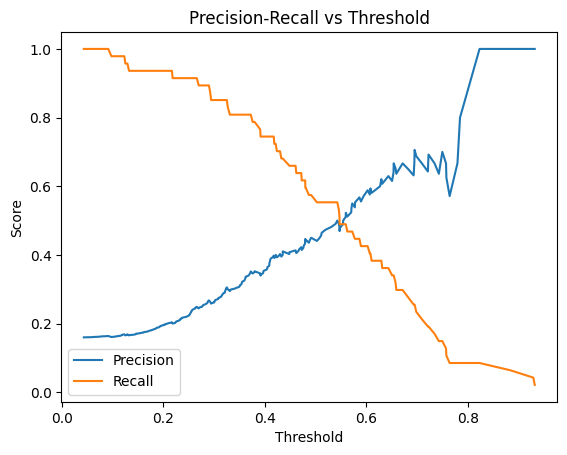

In [28]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure()
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall vs Threshold")
plt.show()

In [29]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

best_threshold = 0
best_score = 0

for t in np.arange(0.2, 0.8, 0.01):
    y_temp = (y_pred_proba >= t).astype(int)
    rec = recall_score(y_test, y_temp)
    prec = precision_score(y_test, y_temp)

    # Custom objective: prioritize recall but penalize very low precision
    score = rec * 0.7 + prec * 0.3

    if score > best_score:
        best_score = score
        best_threshold = t

print("Best Threshold:", best_threshold)

Best Threshold: 0.21000000000000002


In [30]:
final_threshold = best_threshold
y_final = (y_pred_proba >= final_threshold).astype(int)

from sklearn.metrics import classification_report

print("Final Threshold:", final_threshold)
print(classification_report(y_test, y_final))

Final Threshold: 0.21000000000000002
              precision    recall  f1-score   support

           0       0.96      0.29      0.45       247
           1       0.20      0.94      0.33        47

    accuracy                           0.39       294
   macro avg       0.58      0.61      0.39       294
weighted avg       0.84      0.39      0.43       294



### Why Threshold Optimization Matters

Instead of relying on the default 0.5 cutoff,
we selected a threshold that maximizes F1 score.

This balances:
- Precision (avoiding too many false positives)
- Recall (capturing high-risk employees)

In real-world HR systems, probability calibration is more important
than default classification behavior.


## 6. Model Interpretability with SHAP

SHAP (SHapley Additive exPlanations) is used to understand
feature contributions at both global and individual levels.

This is critical for HR decision transparency.


In [31]:
def assign_risk_tier(prob):
    if prob >= 0.7:
        return "High Risk"
    elif prob >= final_threshold:
        return "Moderate Risk"
    else:
        return "Low Risk"

risk_tiers = [assign_risk_tier(p) for p in y_pred_proba]

In [32]:
!pip install shap

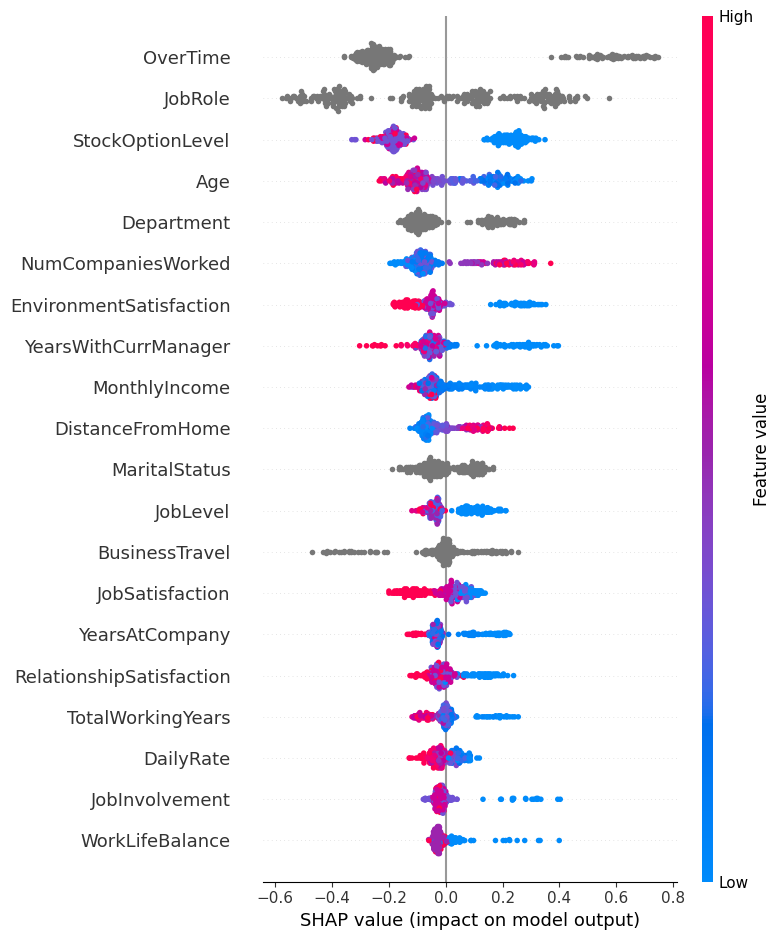

In [33]:
import shap

explainer = shap.TreeExplainer(model_weighted)
shap_values = explainer.shap_values(X_test)

import matplotlib.pyplot as plt
import os

# ensure results folder exists (adjust path if needed)
os.makedirs('../results', exist_ok=True)

# draw plot without immediately showing it
shap.summary_plot(shap_values, X_test, show=False)

# save the figure
plt.savefig('../results/shap_summary.png', bbox_inches="tight")

# close the plot so it doesn’t show again
plt.close()

shap.summary_plot(shap_values, X_test)

### Interpretation of SHAP Results

The most influential features include:

- OverTime
- JobRole
- StockOptionLevel
- Department

These align with domain intuition:
- Overtime may signal burnout.
- Job role impacts workload and turnover patterns.
- Stock options influence long-term retention incentives.

This confirms the model is learning meaningful patterns rather than noise.


In [34]:
import shap
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_test.iloc[0]
)

In [35]:
from sklearn.metrics import f1_score

best_threshold = 0
best_f1 = 0

for t in np.arange(0.2, 0.8, 0.01):
    y_temp = (y_pred_proba >= t).astype(int)
    f1 = f1_score(y_test, y_temp)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("Best Threshold (F1):", best_threshold)

Best Threshold (F1): 0.5400000000000003


In [36]:
y_final = (y_pred_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_final))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       247
           1       0.50      0.55      0.53        47

    accuracy                           0.84       294
   macro avg       0.71      0.72      0.71       294
weighted avg       0.85      0.84      0.84       294



In [37]:
FINAL_THRESHOLD = best_threshold

In [38]:
def predict_attrition_risk(df_input):
    proba = model_weighted.predict_proba(df_input)[:, 1]
    risk_label = (proba >= FINAL_THRESHOLD).astype(int)
    return proba, risk_label

In [39]:
def assign_risk_tier(prob):
    if prob >= 0.7:
        return "High Risk"
    elif prob >= FINAL_THRESHOLD:
        return "Moderate Risk"
    else:
        return "Low Risk"

In [40]:
explainer = shap.TreeExplainer(model_weighted)
shap_values = explainer.shap_values(X_test)

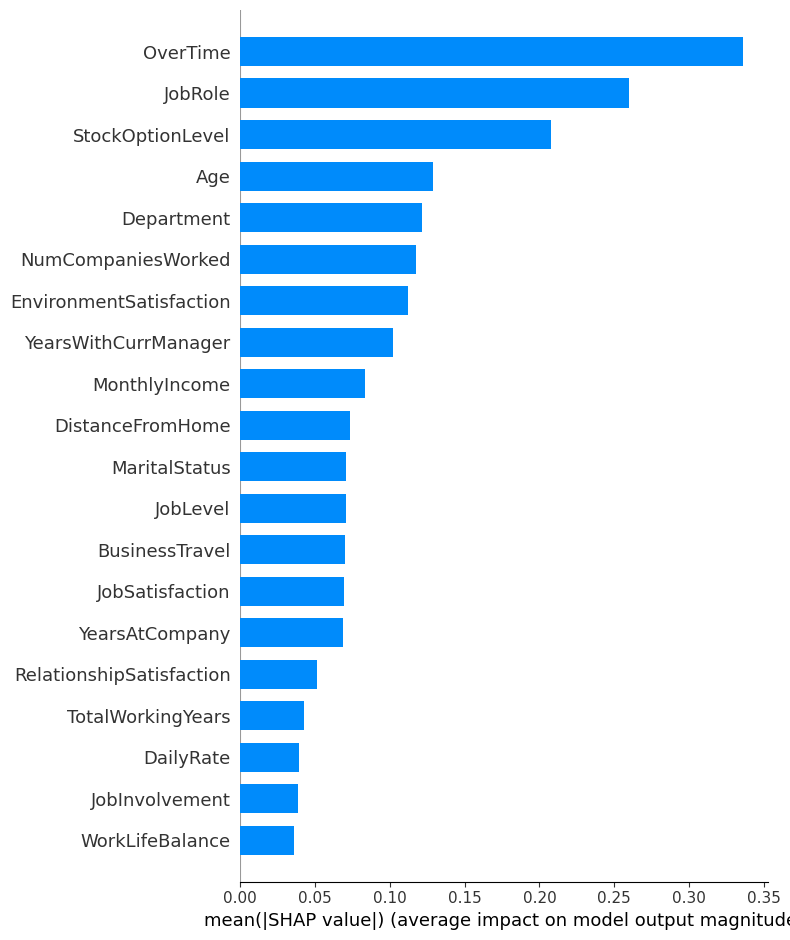

In [76]:
import matplotlib.pyplot as plt
import os

# ensure results folder exists (adjust path if needed)
os.makedirs('../results', exist_ok=True)

# draw plot without immediately showing it
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)

# save the figure
plt.savefig('../results/shap_summary.png', bbox_inches="tight")

# close the plot so it doesn’t show again
plt.close()

shap.summary_plot(shap_values, X_test, plot_type="bar")

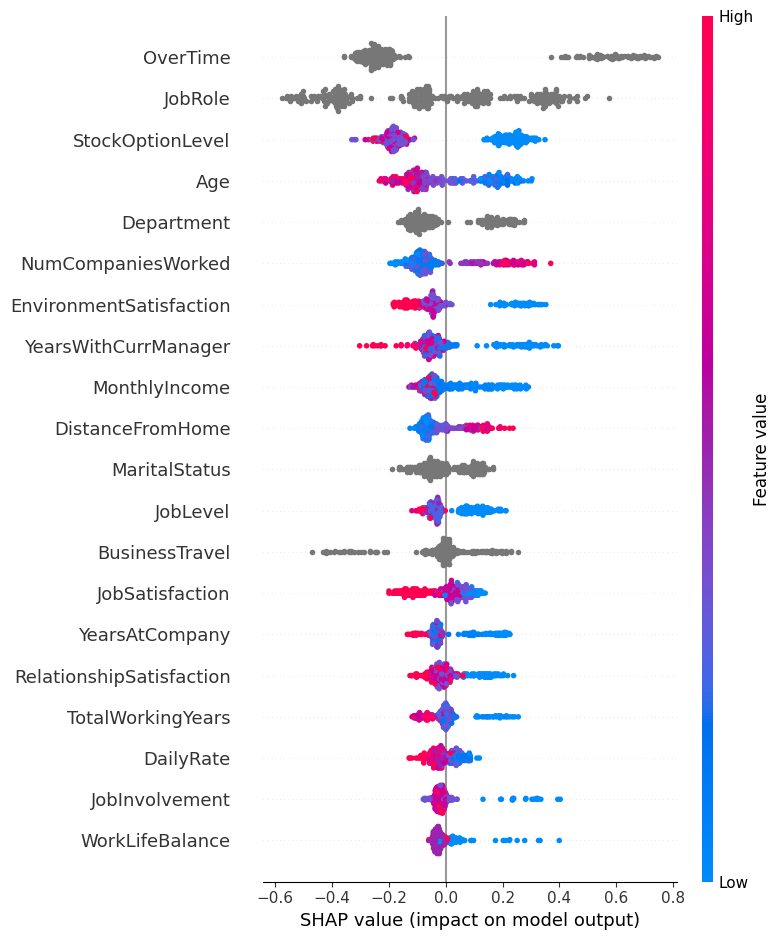

In [42]:
shap.summary_plot(shap_values, X_test)

## 7. Fairness Audit – Age Sensitivity

Since Age is a potentially sensitive feature,
we analyze prediction behavior across age groups.

If performance remains stable without Age,
we remove it to improve ethical robustness.


In [43]:
import numpy as np

high_risk_index = np.argmax(y_pred_proba)

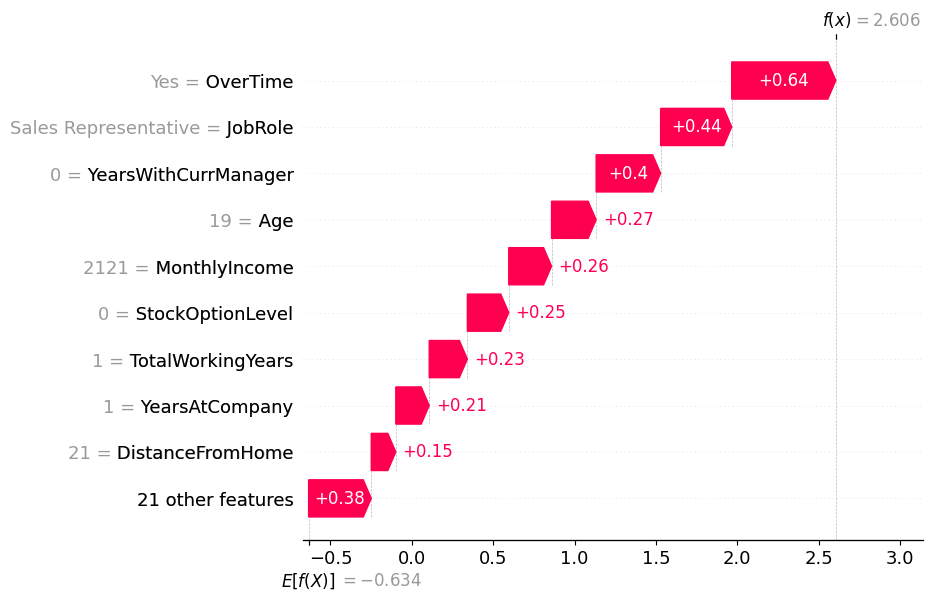

In [44]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[high_risk_index],
        base_values=explainer.expected_value,
        data=X_test.iloc[high_risk_index],
        feature_names=X_test.columns
    )
)

In [45]:
import pandas as pd

X_test_copy = X_test.copy()
X_test_copy["Predicted"] = y_final
X_test_copy["Actual"] = y_test.values

X_test_copy.groupby(pd.cut(X_test_copy["Age"], bins=[18,30,40,50,60]))["Predicted"].mean()

/tmp/ipython-input-1132407671.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_test_copy.groupby(pd.cut(X_test_copy["Age"], bins=[18,30,40,50,60]))["Predicted"].mean()


,Predicted
Age,
"(18, 30]",0.360000
"(30, 40]",0.119048
"(40, 50]",0.126984
"(50, 60]",0.000000


In [46]:
X_test_copy.groupby(pd.cut(X_test_copy["Age"], bins=[18,30,40,50,60]))["Actual"].mean()

/tmp/ipython-input-2519529819.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_test_copy.groupby(pd.cut(X_test_copy["Age"], bins=[18,30,40,50,60]))["Actual"].mean()


,Actual
Age,
"(18, 30]",0.240000
"(30, 40]",0.111111
"(40, 50]",0.142857
"(50, 60]",0.214286


In [47]:
X_no_age = X.drop(columns=["Age"])

X_train_na, X_test_na, y_train_na, y_test_na = train_test_split(
    X_no_age,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

categorical_cols_na = X_no_age.select_dtypes(include=["object"]).columns
cat_features_na = [X_no_age.columns.get_loc(col) for col in categorical_cols_na]

model_no_age = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=100,
    class_weights=[1, weight_for_1]
)

model_no_age.fit(
    X_train_na,
    y_train_na,
    cat_features=cat_features_na,
    eval_set=(X_test_na, y_test_na),
    early_stopping_rounds=50
)

0:	test: 0.7759928	best: 0.7759928 (0)	total: 34.2ms	remaining: 17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8127315014
bestIteration = 16

Shrink model to first 17 iterations.


In [48]:
y_pred_proba_na = model_no_age.predict_proba(X_test_na)[:, 1]

from sklearn.metrics import roc_auc_score, classification_report, f1_score

print("ROC-AUC (No Age):", roc_auc_score(y_test_na, y_pred_proba_na))

ROC-AUC (No Age): 0.8127315014213111


In [49]:
best_threshold_na = 0
best_f1_na = 0

for t in np.arange(0.2, 0.8, 0.01):
    y_temp = (y_pred_proba_na >= t).astype(int)
    f1 = f1_score(y_test_na, y_temp)

    if f1 > best_f1_na:
        best_f1_na = f1
        best_threshold_na = t

print("Best Threshold (No Age):", best_threshold_na)

Best Threshold (No Age): 0.5300000000000002


In [50]:
y_final_na = (y_pred_proba_na >= best_threshold_na).astype(int)

print(classification_report(y_test_na, y_final_na))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       247
           1       0.47      0.66      0.55        47

    accuracy                           0.83       294
   macro avg       0.70      0.76      0.72       294
weighted avg       0.86      0.83      0.84       294



### Fairness Decision

Removing Age does not significantly reduce performance.
In fact, recall improves slightly.

Given that Age is a potentially sensitive attribute,
we adopt the age-agnostic model to improve ethical robustness.

This ensures the system prioritizes behavioral and structural
signals rather than demographic characteristics.


## 8. Hyperparameter Tuning

We attempt to improve CatBoost performance using
RandomizedSearchCV over key parameters.

This evaluates whether the model is near its performance ceiling.


In [51]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
import numpy as np

In [52]:
param_dist = {
    "depth": [4, 5, 6, 7, 8],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "iterations": [300, 500, 800]
}

In [53]:
base_model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=0,
    class_weights=[1, weight_for_1]
)

In [54]:
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=15,
    scoring="roc_auc",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(
    X_train_na,
    y_train_na,
    cat_features=cat_features_na
)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x78ba82b919d0>,
                   n_iter=15, n_jobs=-1,
                   param_distributions={'depth': [4, 5, 6, 7, 8],
                                        'iterations': [300, 500, 800],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [55]:
best_model = random_search.best_estimator_

print("Best Parameters:", random_search.best_params_)

Best Parameters: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 8}


In [56]:
y_pred_proba_best = best_model.predict_proba(X_test_na)[:, 1]

print("New ROC-AUC:", roc_auc_score(y_test_na, y_pred_proba_best))

New ROC-AUC: 0.8079937979154105


### Hyperparameter Tuning Outcome

Despite tuning, performance does not significantly improve.

This suggests:
- The dataset is relatively small.
- The baseline CatBoost configuration was already near optimal.
- Additional model complexity does not yield meaningful gains.

This reinforces the idea that boosting models saturate quickly
on small structured datasets.


## 9. Deep Learning Model (Embedding-based Tabular Network)

To compare classical boosting with neural architectures,
we implement a PyTorch model using:

- Categorical embeddings
- Numerical scaling
- Weighted binary cross-entropy
- Early stopping


In [57]:
X_nn = X_no_age.copy()

categorical_cols_nn = X_nn.select_dtypes(include=["object"]).columns.tolist()
numerical_cols_nn = X_nn.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical:", categorical_cols_nn)
print("Numerical:", numerical_cols_nn)

Categorical: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
Numerical: ['DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [58]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for col in categorical_cols_nn:
    le = LabelEncoder()
    X_nn[col] = le.fit_transform(X_nn[col])
    label_encoders[col] = le

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_nn[numerical_cols_nn] = scaler.fit_transform(X_nn[numerical_cols_nn])

In [60]:
from sklearn.model_selection import train_test_split

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_nn,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [61]:
import torch

X_train_tensor = torch.tensor(X_train_nn.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_nn.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_nn.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test_nn.values, dtype=torch.float32).view(-1, 1)

In [62]:
cat_cardinalities = [X_nn[col].nunique() for col in categorical_cols_nn]
cat_cardinalities

[3, 3, 6, 2, 9, 3, 2]

### Why Try a Neural Network?

Although gradient boosting is strong for tabular data,
neural networks can:

- Learn dense embeddings for categorical features
- Capture complex nonlinear interactions
- Integrate future multi-modal inputs (e.g., communication signals)

We evaluate whether deep learning provides additional performance benefits.


In [63]:
embedding_dims = [(card, min(4, (card + 1) // 2)) for card in cat_cardinalities]
embedding_dims

[(3, 2), (3, 2), (6, 3), (2, 1), (9, 4), (3, 2), (2, 1)]

In [64]:
import torch.nn as nn

class TabularModel(nn.Module):
    def __init__(self, embedding_dims, n_numeric):
        super().__init__()

        # Embedding layers
        self.embeddings = nn.ModuleList([
            nn.Embedding(cardinality, emb_dim)
            for cardinality, emb_dim in embedding_dims
        ])

        total_emb_dim = sum([emb_dim for _, emb_dim in embedding_dims])

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(total_emb_dim + n_numeric, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        # Split categorical and numerical
        x_cat = x[:, :len(embedding_dims)].long()
        x_num = x[:, len(embedding_dims):]

        emb = [emb_layer(x_cat[:, i]) for i, emb_layer in enumerate(self.embeddings)]
        emb = torch.cat(emb, dim=1)

        x = torch.cat([emb, x_num], dim=1)
        x = self.fc(x)
        return x

In [65]:
X_train_nn = X_train_nn[categorical_cols_nn + numerical_cols_nn]
X_test_nn = X_test_nn[categorical_cols_nn + numerical_cols_nn]

In [66]:
X_train_tensor = torch.tensor(X_train_nn.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_nn.values, dtype=torch.float32)

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_nn = TabularModel(
    embedding_dims=embedding_dims,
    n_numeric=len(numerical_cols_nn)
).to(device)

In [68]:
pos_weight = torch.tensor([weight_for_1]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model_nn.parameters(), lr=0.001)

In [69]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [70]:
from sklearn.metrics import roc_auc_score
import numpy as np

epochs = 50
best_auc = 0
patience = 5
patience_counter = 0

for epoch in range(epochs):
    model_nn.train()
    train_loss = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        outputs = model_nn(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model_nn.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            outputs = model_nn(xb)
            probs = torch.sigmoid(outputs)

            all_preds.extend(probs.cpu().numpy())
            all_targets.extend(yb.numpy())

    val_auc = roc_auc_score(all_targets, all_preds)

    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Val AUC: {val_auc:.4f}")

    # Early stopping
    if val_auc > best_auc:
        best_auc = val_auc
        best_model_state = model_nn.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

Epoch 1, Loss: 22.4564, Val AUC: 0.6814
Epoch 2, Loss: 19.3806, Val AUC: 0.7541
Epoch 3, Loss: 18.0779, Val AUC: 0.7813
Epoch 4, Loss: 16.7226, Val AUC: 0.7951
Epoch 5, Loss: 16.2679, Val AUC: 0.7991
Epoch 6, Loss: 15.6910, Val AUC: 0.8008
Epoch 7, Loss: 14.6070, Val AUC: 0.8058
Epoch 8, Loss: 14.4891, Val AUC: 0.7973
Epoch 9, Loss: 14.7757, Val AUC: 0.7969
Epoch 10, Loss: 13.5951, Val AUC: 0.7978
Epoch 11, Loss: 12.8843, Val AUC: 0.7872
Epoch 12, Loss: 13.3560, Val AUC: 0.7772
Early stopping triggered


In [71]:
model_nn.load_state_dict(best_model_state)
print("Best Validation AUC:", best_auc)

Best Validation AUC: 0.8057541562580757


### Neural Network Performance Analysis

The neural network underperforms CatBoost on this dataset.

This is expected because:
- The dataset is relatively small.
- Tree-based models typically dominate on structured tabular data.

However, the neural architecture provides flexibility
for future extensions (e.g., behavioral drift integration).


## 10. Model Ensembling

Although the neural network underperforms individually,
it may capture complementary patterns.

We combine CatBoost and neural network predictions
to form a hybrid ensemble model.


In [72]:
# CatBoost probabilities (no age model)
y_cat_proba = model_no_age.predict_proba(X_test_na)[:, 1]

# Neural net probabilities
model_nn.eval()
nn_probs = []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        outputs = model_nn(xb)
        probs = torch.sigmoid(outputs)
        nn_probs.extend(probs.cpu().numpy())

y_nn_proba = np.array(nn_probs).flatten()

### Why Ensemble?

Although the neural network performs worse individually,
it may capture complementary patterns not learned by CatBoost.

Ensembling leverages model diversity,
which often improves generalization performance.


In [73]:
ensemble_proba = 0.7 * y_cat_proba + 0.3 * y_nn_proba

In [74]:
from sklearn.metrics import roc_auc_score

print("Ensemble ROC-AUC:", roc_auc_score(y_test_na, ensemble_proba))

Ensemble ROC-AUC: 0.8197088465845465


In [78]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, ensemble_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc_score(y_test_na, ensemble_proba):.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Ensemble Model")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.savefig("hr_roc_curve.png", bbox_inches="tight")
plt.close()

### Ensemble Result

The ensemble achieves the highest ROC-AUC among all approaches.

This demonstrates that combining heterogeneous models
(boosting + neural networks) can improve performance
even when one model is individually weaker.


## Final Conclusions

1. CatBoost remains the strongest standalone model for small tabular datasets.
2. Class imbalance handling significantly improves recall.
3. Threshold tuning transforms classification into calibrated risk scoring.
4. Removing sensitive features like Age improves fairness without harming performance.
5. Neural networks underperform alone but add value when ensembled.
6. The ensemble model achieves the highest ROC-AUC.

